In [1]:
import requests
import sys
import time
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import math

class BaiduIndexScrapyer:
    
    def __init__(self, keyword, start, end, cookies):
        self.word_url = 'http://index.baidu.com/api/SearchApi/thumbnail?area=0&word={}'
        self.keyword = keyword
        self.start = start
        self.end = end
        self.cookies = cookies
    
    def decrypt(self, t, e):
        n = list(t)
        i = list(e)
        a = {}
        result = []
        ln = int(len(n) / 2)
        start = n[ln:]
        end = n[:ln]
        for j, k in zip(start, end):
            a.update({k: j})
        for j in e:
            result.append(a.get(j))
        return ''.join(result)

    def get_index_home(self, keyword):
        headers = {
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.90 Safari/537.36',
            'Cookie': self.cookies
        }
        word_url = f'http://index.baidu.com/api/SearchApi/thumbnail?area=0&word=[[%7B%22name%22:%22{keyword}%22,%22wordType%22:1%7D]]'
        resp = requests.get(word_url, headers=headers)
        j = resp.json()

        print(j)

        uniqid = j.get('data').get('uniqid')
        return get_ptbk(uniqid)

    def get_ptbk(self, uniqid):
        url = 'http://index.baidu.com/Interface/ptbk?uniqid={}'
        ptbk_headers = {
            'Accept': 'application/json, text/plain, */*',
            'Accept-Encoding': 'gzip, deflate',
            'Accept-Language': 'zh-CN,zh;q=0.9',
            'Cache-Control': 'no-cache',
            'Cookie': self.cookies,
            'DNT': '1',
            'Host': 'index.baidu.com',
            'Pragma': 'no-cache',
            'Proxy-Connection': 'keep-alive',
            'Referer': 'http://index.baidu.com/v2/index.html',
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.90 Safari/537.36',
            'X-Requested-With': 'XMLHttpRequest',
        }
        print(url.format(uniqid))
        resp = requests.get(url.format(uniqid), headers=ptbk_headers)

        # HTTP Response failed
        if resp.status_code != 200:
            print('Failed to get uniqid')
            sys.exit(1)

        return resp.json().get('data')

    def get_index_data(self, keyword, start, end):
        url = f'http://index.baidu.com/api/SugApi/sug?inputword[]={keyword}&area=0&startDate={start}&endDate={end}'
        word_param = f'[[%7B"name":"{keyword}","wordType":1%7D]]'
        url1 = f'http://index.baidu.com/api/SearchApi/index?area=0&word={word_param}&startDate={start}&endDate={end}'
        print(url1 + "\n")
        headers = {
            'Accept': 'application/json, text/plain, */*',
            'Accept-Encoding': 'gzip, deflate',
            'Accept-Language': 'zh-CN,zh;q=0.9',
            'Cache-Control': 'no-cache',
            'Cookie': self.cookies,
            'DNT': '1',
            'Host': 'index.baidu.com',
            'Pragma': 'no-cache',
            'Proxy-Connection': 'keep-alive',
            'Referer': 'http://index.baidu.com/v2/index.html',
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.90 Safari/537.36',
            'X-Requested-With': 'XMLHttpRequest',
        }

        resp = requests.get(url1, headers=headers)

        # HTTP Response failed
        if resp.status_code != 200:
            print('Error happens when fetching index')
            sys.exit(1)

        data = resp.json().get('data').get('userIndexes')[0]
        uniqid = resp.json().get('data').get('uniqid')
        ptbk = self.get_ptbk(uniqid)
        all_data = data.get('all').get('data')
        result = self.decrypt(ptbk, all_data)
        result = result.split(',')
        return result

    def get(self):
        str_data = self.get_index_data(keyword=self.keyword, start=self.start, end=self.end)
        int_data = []
        date_i = self.start
        date = []
        for d in str_data:
            date.append(date_i)
            date_i += datetime.timedelta(days=1)
            int_data.append(int(d))
        df = pd.DataFrame(date, columns=['date'])
        df = pd.concat([df, pd.DataFrame(int_data, columns=['search_index'])], axis=1)
        return df

    def plot(self, data):
        import matplotlib.pyplot as plt
        x = data.date
        y = data.search_index
        plt.plot(x, y)

In [8]:
# Baidu Index Scrapping
startDate = datetime.datetime(2020, 8, 30)
endDate = datetime.date.today()
keyword = '股票'
cookies = 'BDUSS=npzcndvZWxlYX5KMjg2bXpqOWdzUDQ2SE96Vkt2MlNMZjFaSVhEakpNY0lSeTlnRVFBQUFBJCQAAAAAAAAAAAEAAAANy6Vatv679db30uWBVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAi6B2AIugdgV; CHKFORREG=d653076750ed5b3ac7f12752f0cb663d; bdindexid=2s3g96u5kg5d0hit2esila5l80; Hm_lvt_d101ea4d2a5c67dab98251f0b5de24dc=1611123855,1611124055,1611125046,1611125162; Hm_lpvt_d101ea4d2a5c67dab98251f0b5de24dc=1611125913; __yjsv5_shitong=1.0_7_30c41c549108ec4a61f1658b1d80c3d142b4_300_1611125913587_202.86.179.90_c26b5af6; BAIDUID=9C7892480E03E397AA2C4A324AB1A841:FG=1; RT="z=1&dm=baidu.com&si=rgjbcrll45&ss=kk4ypmbo&sl=1m&tt=i1s2&bcn=https%3A%2F%2Ffclog.baidu.com%2Flog%2Fweirwood%3Ftype%3Dperf&ld=4jaj7&ul=4u4h4"'
bis = BaiduIndexScrapyer(keyword, start=startDate, end=endDate, cookies=cookies)
data = bis.get()
bis_x = data.date
bis_y = data.search_index

# Retriving Shanghai Components - 000001.SS
ss = web.DataReader('000001.SS', 'yahoo', startDate, endDate)

http://index.baidu.com/api/SearchApi/index?area=0&word=[[%7B"name":"股票","wordType":1%7D]]&startDate=2020-11-30 00:00:00&endDate=2021-02-04

http://index.baidu.com/Interface/ptbk?uniqid=36d9b443bbe4b26c18167813320d8720


## Plot

Blue: Baidu Search Index

Red: Shanghai Component

         date  search_index
0  2020-11-30         15553
1  2020-12-01         15651
2  2020-12-02         16631
3  2020-12-03         15221
4  2020-12-04         13723
..        ...           ...
60 2021-01-29         32425
61 2021-01-30          8275
62 2021-01-31          5923
63 2021-02-01         25956
64 2021-02-02         24300

[65 rows x 2 columns]


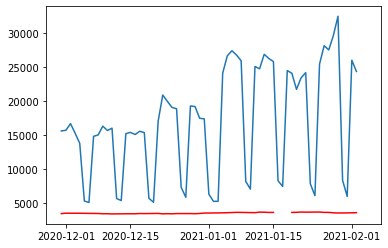

In [9]:
print(data)
plt.plot(bis_x, bis_y)
plt.plot(ss.Close, color='red')
plt.show()

## Optimizing Visual Graph

Solving the variation of SS is too weak.

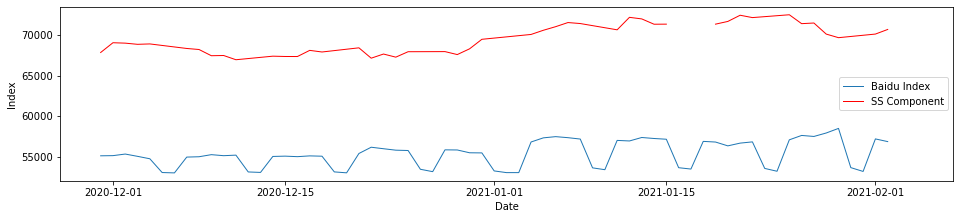

In [10]:
bis_y_opt = bis_y / 5 + 52000
ss_Close_opt = ss.Close * 20

from matplotlib.figure import figaspect

w, h = figaspect(1/5)
fig, ax = plt.subplots(figsize=(w,h))
plt.legend(labels=['up','down'],loc='best')

plt.xlabel('Date')
plt.ylabel('Index')
plt.plot(bis_x, bis_y_opt, linewidth=1, label='Baidu Index')
plt.plot(ss_Close_opt, color='red', linewidth=1, label='SS Component')
plt.legend()
plt.savefig('Plot.png', dpi=300)